In [1]:
import pandas as pd
import numpy as np

In [2]:
# read text sequence dataset
train_seq_df = pd.read_csv("datasets/train/train_text_seq.csv")
train_seq_X = train_seq_df['input_str'].tolist()
train_seq_Y = train_seq_df['label'].tolist()

valid_seq_df = pd.read_csv("datasets/valid/valid_text_seq.csv")
valid_seq_X = valid_seq_df['input_str'].tolist()
valid_seq_Y = valid_seq_df['label'].tolist()

test_seq_X = pd.read_csv("datasets/test/test_text_seq.csv")['input_str'].tolist()

In [3]:
print(f"Train dataset size: ")
print(f"train_seq_X: {len(train_seq_X)} train_seq_Y: {len(train_seq_Y)}")

print()
print("Test dataset size: ")
print(f"test_seq_X: {len(test_seq_X)}")

print()
print(f"Validation dataset size: ")
print(f"valid_seq_X: {len(valid_seq_X)} valid_seq_Y: {len(valid_seq_Y)}")

Train dataset size: 
train_seq_X: 7080 train_seq_Y: 7080

Test dataset size: 
test_seq_X: 2232

Validation dataset size: 
valid_seq_X: 489 valid_seq_Y: 489


### Dataset
* The key observation is that this dataset is similar to the emoticon dataset. Every example has a padding of zeros in the beginnning. Every emoticon is encoded as a sequence of 3-5 digits in this dataset.
* So, similar to the first dataset, we chose to train a LSTM model since it would learn the local patterns (individual emoticons) as well as the long-term memory (the sequence of empticons). 
* Every digit is embedded as a 16-dim vector.
* The model is expected to have a lower accuracy than that in the emoticon dataset because there is a loss of information in learning the encoding of the emoticons.
* **Other ML methods tried**: 
    - Tried kernelized svm, used rbf kernel, polynomial kernel (degree = 3) and linear kernel but was getting accuracy less than 70%. So, we started to treat the input digits as a sequence rather than individual features.
    - Also tried n-gram feature extraction (n = 3-6), thinking it would learn the digit encodings of each emoticon but could not get reasonable results

In [4]:
train_seq_df

,input_str,label
0,0000154364642718159661428002624223132284159626...,0
1,0004641596369515436422262614110471596262476161...,0
2,0001543626215965999614422464135806142624051159...,0
3,0000154364224641238614262159689561596284351061...,1
4,0004641899422154362069015966142624761262159661...,1
...,...,...
7075,0000026267027181596614464154364222842626141596...,1
7076,0000464422155826261433491543615961596284614390...,1
7077,0003069915964309154366142624644222841795262614...,1
7078,0000614159615436198346426242237758262159694061...,0


In [5]:
train_seq_df['input_str'].str.lstrip('0')

0        1543646427181596614280026242231322841596262614
1       46415963695154364222626141104715962624761614284
2       15436262159659996144224641358061426240511596284
3        1543642246412386142621596895615962843510614262
4       46418994221543620690159661426247612621596614284
                             ...                       
7075      262670271815966144641543642228426261415962414
7076     4644221558262614334915436159615962846143901262
7077    30699159643091543661426246442228417952626141596
7078     6141596154361983464262422377582621596940614284
7079     1543661442215964644761262192315966141899262284
Name: input_str, Length: 7080, dtype: object

In [6]:
train_seq_X_new = train_seq_df['input_str'].str.lstrip('0')
valid_seq_X_new = valid_seq_df['input_str'].str.lstrip('0')
test_seq_X_new = pd.Series(test_seq_X).str.lstrip('0').tolist()

### LSTM

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the LSTM model with learned embeddings
class LSTMClassifierWithEmbedding(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size, learning_rate=0.001):
        super(LSTMClassifierWithEmbedding, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=input_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
        self.criterion = nn.BCEWithLogitsLoss()

    def forward(self, x):
        x = self.embedding(x)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])
        return out

    # Method to train the model
    def train_model(self, train_loader, num_epochs):
        self.train()
        for epoch in range(num_epochs):
            epoch_loss = 0
            for batch_sequences, batch_labels in train_loader:
                outputs = self(batch_sequences)
                loss = self.criterion(outputs, batch_labels)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
            # Optionally print the epoch loss
            # print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss / len(train_loader):.4f}')
        return self

    # Method to evaluate the model
    def evaluate_model(self, val_loader):
        self.eval()
        all_labels = []
        all_predictions = []
        with torch.no_grad():
            for val_sequences, val_labels in val_loader:
                outputs = self(val_sequences)
                predictions = torch.sigmoid(outputs).round()
                all_labels.extend(val_labels.cpu().numpy())
                all_predictions.extend(predictions.cpu().numpy())
        accuracy = accuracy_score(all_labels, all_predictions)
        return accuracy


C:\Users\ASUS\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Function to print Classification Report and Confusion Matrix

In [8]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def print_classification_report_and_confusion_matrix(model, dataloader, class_names=None):
    """
    Prints the classification report and confusion matrix for a given PyTorch model and dataloader.

    Parameters:
    model (nn.Module): Trained PyTorch model.
    dataloader (DataLoader): Dataloader containing validation/test data.
    class_names (list, optional): List of class names for labeling confusion matrix. Defaults to None.
    """
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            predictions = torch.sigmoid(outputs).round()  # Assuming binary classification, modify for multi-class
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predictions.cpu().numpy())
    
    # Generate the classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names))
    
    # Generate the confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()


In [9]:
import random
import numpy as np
import torch

def reset_random_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

### Function to Train the model on different Fractions of Data

In [10]:
# Main function to encapsulate the entire training, validation, and best model saving process
def run_training(fractions, sequence_tensors, labels_tensor, val_sequence_tensors, val_labels_tensor, input_size, embedding_dim, hidden_size, output_size, learning_rate, num_epochs, batch_size):
    val_accuracies = []
    full_model = None
    best_accuracy = 0.0
    best_frac = 0.0

    val_dataset = TensorDataset(val_sequence_tensors, val_labels_tensor)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for fraction in fractions:
        num_samples = int(len(sequence_tensors) * fraction)
        fraction_sequences = sequence_tensors[:num_samples]
        fraction_labels = labels_tensor[:num_samples]

        train_dataset = TensorDataset(fraction_sequences, fraction_labels)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        best_model = None
        val_accuracy = 0.0
        # Reset seeds and initialize the model
        for seed in [0,1]:
            reset_random_seeds(seed)  # Reset with a seed value
            model = LSTMClassifierWithEmbedding(input_size, embedding_dim, hidden_size, output_size, learning_rate)
            # Train the model
            model.train_model(train_loader, num_epochs)
            # Evaluate the model on the validation set
            if model.evaluate_model(val_loader) > val_accuracy:
                val_accuracy = model.evaluate_model(val_loader)
                best_model = model
        val_accuracies.append(val_accuracy * 100)
        
        print("----------------------------------------------------------")
        print(f"Fraction: {fraction}, Validation Accuracy: {val_accuracy * 100:.2f}%")
        print("----------------------------------------------------------")
        
        class_names = ['Class 0', 'Class 1']
        print_classification_report_and_confusion_matrix(best_model, val_loader, class_names)

        # Save the best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_frac = fraction
        
        full_model = best_model
        
    # Plot validation accuracy vs. fraction of training data
    plt.plot(fractions, val_accuracies, marker='o')
    plt.title('Validation Accuracy vs. Fraction of Training Data')
    plt.xlabel('Fraction of Training Data')
    plt.ylabel('Validation Accuracy')
    plt.xticks(fractions)
    plt.grid()
    plt.show()

    # Save the best model to disk
    # torch.save(best_model, 'best_lstm_model.pth')
    print("=======================================")
    print(f'Best Validation Accuracy was for Fraction = {best_frac}: {best_accuracy*100:.2f}%')
    print("=======================================")
    
    return best_model

In [11]:
# Convert sequence of digits into tensor (just a list of numbers)
def digit_sequence_to_tensor(sequence):
    return torch.tensor([int(digit) for digit in sequence], dtype=torch.long)

In [12]:
# Convert sequences to tensor format (each sequence is a list of digit indices)
sequence_tensors = [digit_sequence_to_tensor(seq) for seq in train_seq_X]
sequence_tensors = torch.stack(sequence_tensors)  # Stack to form a batch tensor

val_sequence_tensors = [digit_sequence_to_tensor(seq) for seq in valid_seq_X]
val_sequence_tensors = torch.stack(val_sequence_tensors)  # Stack to form a batch tensor

# Convert labels to tensor
labels_tensor = torch.tensor(train_seq_Y).float().unsqueeze(1)  # Convert labels to tensor and reshape

val_labels_tensor = torch.tensor(valid_seq_Y).float().unsqueeze(1)

----------------------------------------------------------
Fraction: 0.2, Validation Accuracy: 69.94%
----------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.70      0.74      0.72       252
     Class 1       0.70      0.65      0.68       237

    accuracy                           0.70       489
   macro avg       0.70      0.70      0.70       489
weighted avg       0.70      0.70      0.70       489



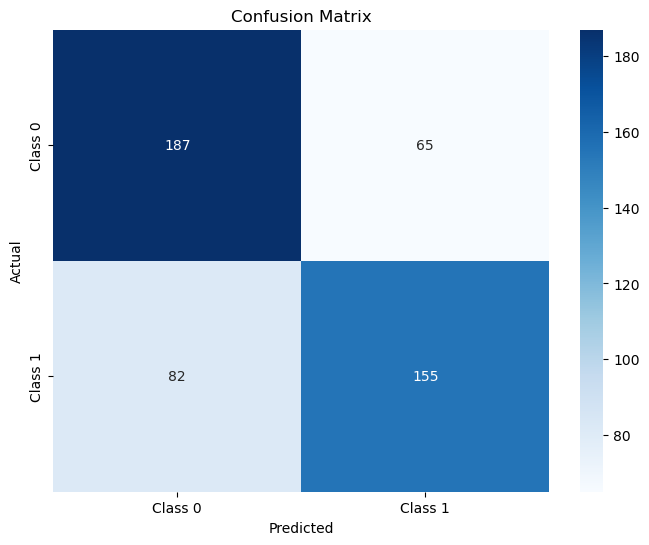

----------------------------------------------------------
Fraction: 0.4, Validation Accuracy: 76.07%
----------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.79      0.77       252
     Class 1       0.76      0.73      0.75       237

    accuracy                           0.76       489
   macro avg       0.76      0.76      0.76       489
weighted avg       0.76      0.76      0.76       489



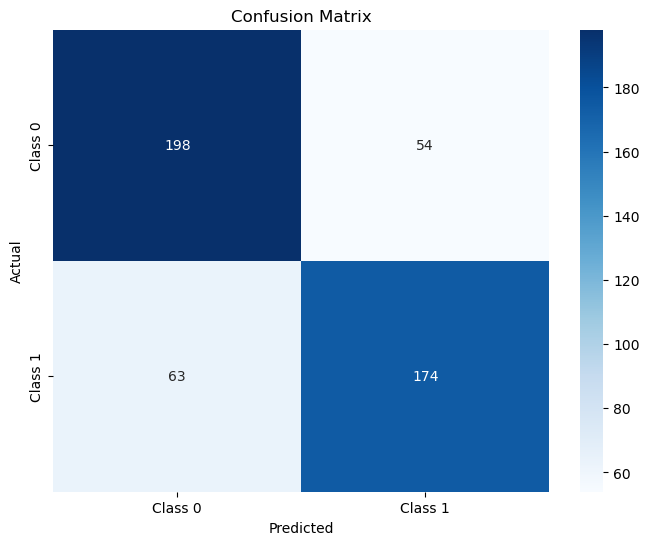

----------------------------------------------------------
Fraction: 0.6, Validation Accuracy: 82.62%
----------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.83      0.83       252
     Class 1       0.82      0.83      0.82       237

    accuracy                           0.83       489
   macro avg       0.83      0.83      0.83       489
weighted avg       0.83      0.83      0.83       489



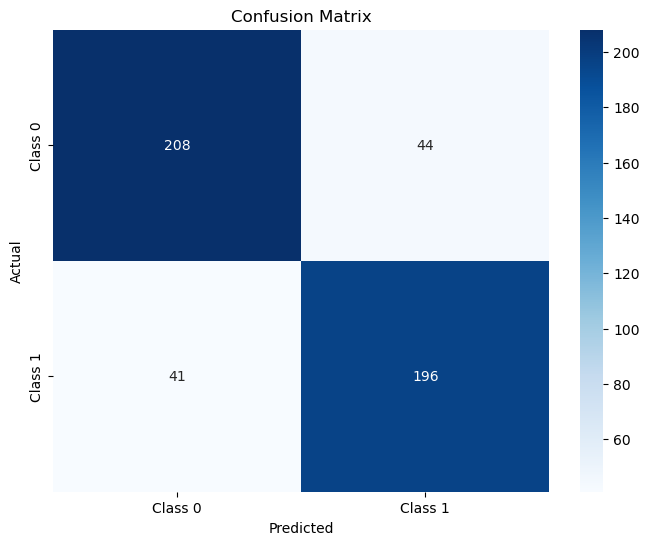

----------------------------------------------------------
Fraction: 0.8, Validation Accuracy: 84.46%
----------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.86      0.85       252
     Class 1       0.85      0.83      0.84       237

    accuracy                           0.84       489
   macro avg       0.84      0.84      0.84       489
weighted avg       0.84      0.84      0.84       489



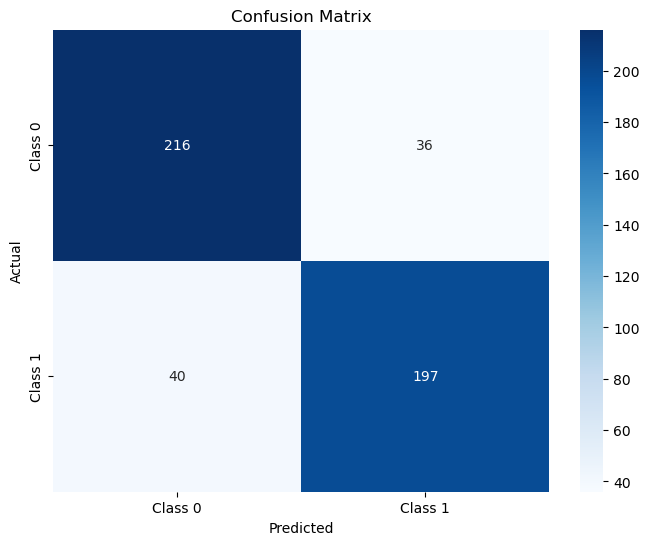

----------------------------------------------------------
Fraction: 1.0, Validation Accuracy: 89.78%
----------------------------------------------------------
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.91      0.89      0.90       252
     Class 1       0.88      0.91      0.90       237

    accuracy                           0.90       489
   macro avg       0.90      0.90      0.90       489
weighted avg       0.90      0.90      0.90       489



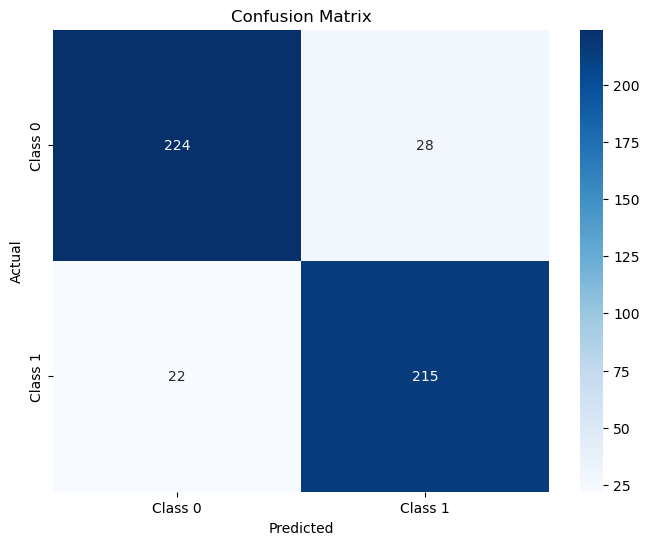

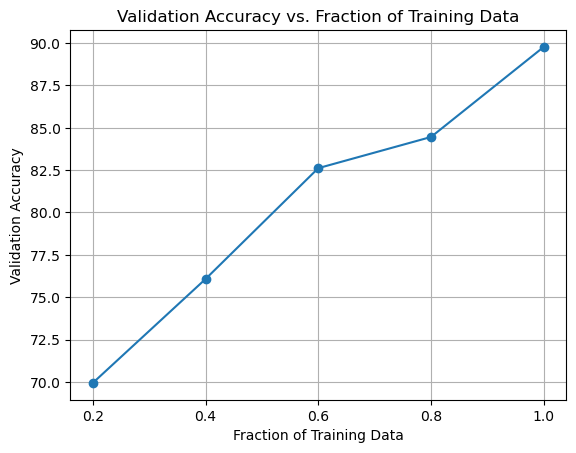

Best Validation Accuracy was for Fraction = 1.0: 89.78%


In [13]:
# Hyperparameters
fractions = [0.2, 0.4, 0.6, 0.8, 1.0]
input_size = 10        # Number of possible digits (0-9)
embedding_dim = 16     # Size of the embedding vector for each digit
hidden_size = 40       # Size of the LSTM hidden state
output_size = 1        # Binary classification (0 or 1)
learning_rate = 0.0015
num_epochs = 25 # 18 # 25
batch_size = 16 # 8 # 16

# Prepare your data as tensors (sequence_tensors, labels_tensor, val_sequence_tensors, val_labels_tensor)

# Call the run_training function
full_model = run_training(fractions, sequence_tensors, labels_tensor, val_sequence_tensors, val_labels_tensor, input_size, embedding_dim, hidden_size, output_size, learning_rate, num_epochs, batch_size)

### Number of learned parameters

In [14]:
# # Function to calculate the number of parameters
# def count_parameters(model):
#     return sum(p.numel() for p in model.parameters()) # if p.requires_grad

# # Print the total number of learned parameters
# total_params = count_parameters(best_model)
# print(f'Total number of learned parameters: {total_params}')

In [15]:
!pip install torchinfo
!pip install torchsummary
from torchinfo import summary

In [16]:
summary(full_model)

Layer (type:depth-idx)                   Param #
LSTMClassifierWithEmbedding              --
├─Embedding: 1-1                         160
├─LSTM: 1-2                              9,280
├─Linear: 1-3                            41
├─BCEWithLogitsLoss: 1-4                 --
Total params: 9,481
Trainable params: 9,481
Non-trainable params: 0

### Test Predictions

In [17]:
# Convert test sequences to tensors
test_sequence_tensors = [digit_sequence_to_tensor(seq) for seq in test_seq_X]
test_sequence_tensors = torch.stack(test_sequence_tensors)  # Stack to form a batch tensor

In [18]:
# Set the model to evaluation mode
full_model.eval()

# Make predictions on the test set
predictions = []
with torch.no_grad():
    for test_sequence in test_sequence_tensors:
        test_sequence = test_sequence.unsqueeze(0)  # Add batch dimension
        output = full_model(test_sequence)
        prediction = torch.sigmoid(output).round().item()  # Get binary prediction (0/1)
        predictions.append(int(prediction))

In [19]:
# Save the predictions to a text file
with open('pred_textseq.txt', 'w') as f:
    for prediction in predictions:
        f.write(f'{prediction}\n')

print(f'Predictions saved to pred_textseq.txt')

Predictions saved to pred_textseq.txt
